Librerías importadas correctamente.

Localizando el dataset (usará la caché si ya existe)...
Dataset (desde caché o descarga) localizado en: C:\Users\julia\.cache\kagglehub\datasets\madhavmalhotra\unb-cic-iot-dataset\versions\1

Accediendo al directorio de CSVs: C:\Users\julia\.cache\kagglehub\datasets\madhavmalhotra\unb-cic-iot-dataset\versions\1\wataiData\csv\CICIoT2023
¡Éxito! Se encontraron 169 archivos CSV.

Cargando el primer archivo como muestra: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv...
Muestra cargada correctamente.

--- Información General del Dataset (Muestra del primer CSV) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238687 entries, 0 to 238686
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    238687 non-null  float64
 1   Header_Length    238687 non-null  float64
 2   Protocol Type    238687 non-null  float64
 3   Duration         238687 non-null  

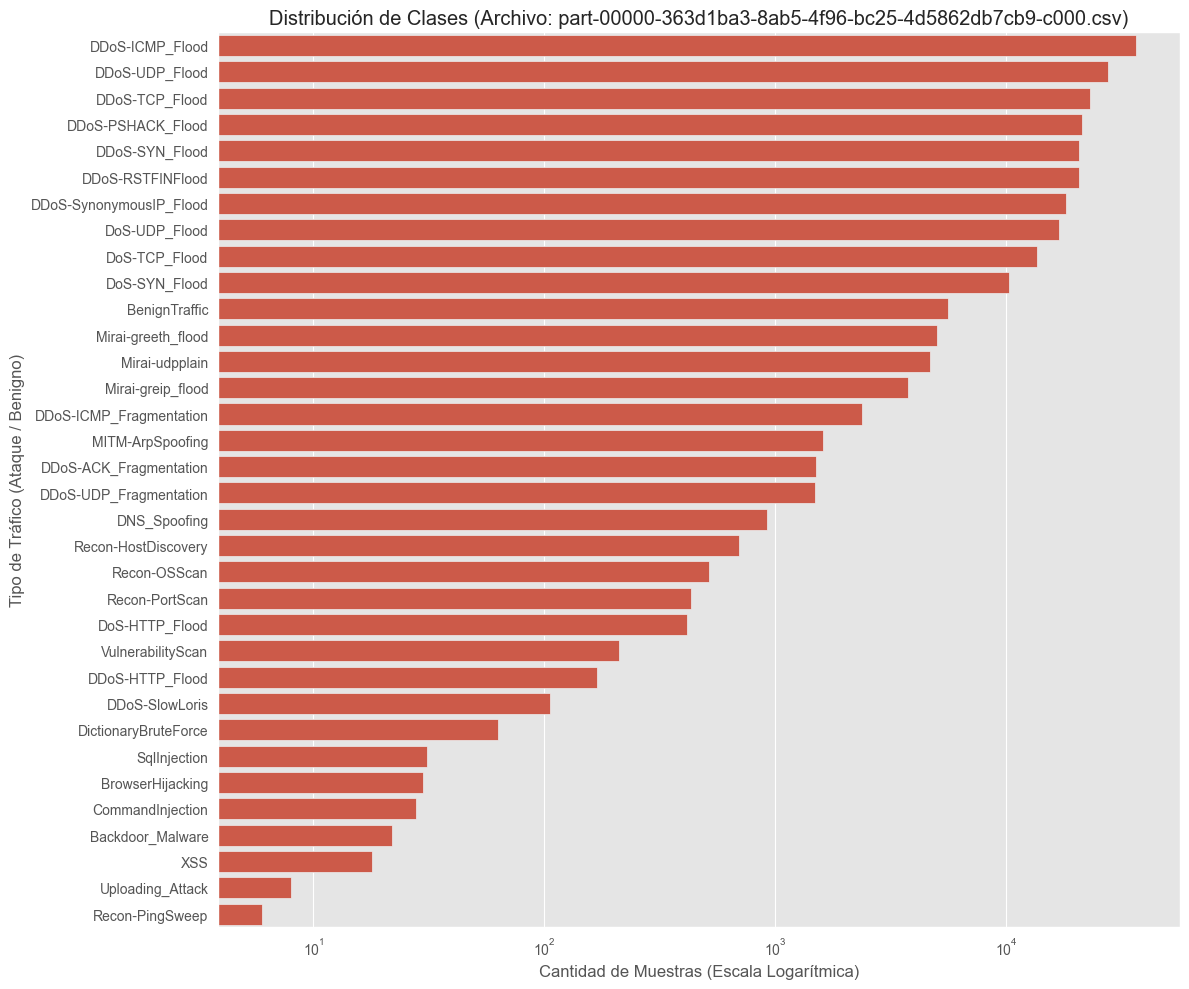

In [1]:
# ----------------------------------------------
# ETAPA 1 (Corregida): Carga, Descarga y Análisis (EDA)
# ----------------------------------------------

# --- 1. Importación de Librerías ---
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.src.layers import BatchNormalization

print("Librerías importadas correctamente.")

# Configuración de Pandas y Matplotlib
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')

# --- 2. Descarga del Dataset (Usando Caché) ---
print("\nLocalizando el dataset (usará la caché si ya existe)...")
download_path = ""
try:
    # -----------------------------------------------------------------
    # NOTA: Esta función es 'cache-aware'.
    # Si ya descargaste el dataset, NO lo volverá a bajar.
    # Simplemente te dará la ruta a los archivos existentes en caché.
    # -----------------------------------------------------------------
    download_path = kagglehub.dataset_download("madhavmalhotra/unb-cic-iot-dataset")
    print(f"Dataset (desde caché o descarga) localizado en: {download_path}")

except Exception as e:
    print(f"ERROR al descargar: {e}")
    print("Por favor, verifica tu conexión y que 'kaggle.json' esté en el lugar correcto.")


# --- 3. Búsqueda y Carga del CSV ---
# Esta es la ruta base que devuelve kagglehub
base_download_path = download_path

# Construimos la ruta correcta que descubrimos
csv_directory = os.path.join(base_download_path, 'wataiData', 'csv', 'CICIoT2023')
print(f"\nAccediendo al directorio de CSVs: {csv_directory}")

csv_file_path = ""
df_sample = None

try:
    # Listar todos los archivos en ese directorio
    all_csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

    if not all_csv_files:
        print("ERROR: No se encontraron archivos .csv en el directorio especificado.")
    else:
        print(f"¡Éxito! Se encontraron {len(all_csv_files)} archivos CSV.")

        # --- 4. Carga de MUESTRA (Sampling) ---
        # No cargaremos los 169 archivos.
        # Para el análisis, cargaremos solo el PRIMER archivo de la lista.

        first_csv_file = all_csv_files[0]
        csv_file_path = os.path.join(csv_directory, first_csv_file)

        print(f"\nCargando el primer archivo como muestra: {first_csv_file}...")

        df_sample = pd.read_csv(csv_file_path)

        print("Muestra cargada correctamente.")

except FileNotFoundError:
    print(f"ERROR: El directorio {csv_directory} no existe. Verifica la ruta.")
except Exception as e:
    print(f"Ocurrió un error al listar o cargar archivos: {e}")


# --- 5. Análisis de Clases (Si la carga fue exitosa) ---
if df_sample is not None:
    try:
        print("\n--- Información General del Dataset (Muestra del primer CSV) ---")
        df_sample.info()

        print("\n--- Primeras 5 filas (para ver columnas) ---")
        print(df_sample.head())

        #################################################################
        # ¡IMPORTANTE!
        # Revisa la salida de 'df_sample.head()' y confirma
        # el nombre de la columna de etiquetas.
        # Cámbialo aquí si es necesario.
        LABEL_COLUMN_NAME = 'label'
        #################################################################

        if LABEL_COLUMN_NAME in df_sample.columns:
            print(f"\n--- Distribución de Clases (Columna: '{LABEL_COLUMN_NAME}') ---")
            class_distribution = df_sample[LABEL_COLUMN_NAME].value_counts()
            print(class_distribution)

            # --- 6. Visualización de Clases ---
            print("\nGenerando gráfico de distribución de clases...")
            plt.figure(figsize=(12, 10))

            sns.countplot(y=df_sample[LABEL_COLUMN_NAME],
                          order=class_distribution.index)

            plt.title(f'Distribución de Clases (Archivo: {first_csv_file})')
            plt.xlabel('Cantidad de Muestras (Escala Logarítmica)')
            plt.ylabel('Tipo de Tráfico (Ataque / Benigno)')
            plt.xscale('log')
            plt.tight_layout()
            plt.show()

        else:
            print(f"\n--- ERROR DE ANÁLISIS ---")
            print(f"No se encontró la columna '{LABEL_COLUMN_NAME}'.")
            print(f"Las columnas disponibles son: {df_sample.columns.tolist()}")
            print("Por favor, actualiza la variable 'LABEL_COLUMN_NAME' en el script.")

    except Exception as e:
        print(f"Ocurrió un error durante el análisis: {e}")

In [2]:
# ----------------------------------------------
# ETAPA 2 Preprocesamiento y Limpieza
# ----------------------------------------------

# --- 1. Importaciones Adicionales ---
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# (Asumimos que 'df_sample' todavía existe en memoria de la Etapa 1)
# Si no, vuelve a cargar el primer CSV:
# csv_file_path = ... (ruta al primer csv)
# df_sample = pd.read_csv(csv_file_path)

print(f"--- DataFrame Original (Muestra) ---")
print(f"Forma original: {df_sample.shape}")

# --- 2. 🧹 Limpieza de Nombres de Columnas ---
# ¡IMPORTANTE! Arreglamos los nombres con espacios (ej. 'Protocol Type')
# Reemplazamos ' ' por '_' y convertimos a minúsculas
original_columns = df_sample.columns.tolist()
df_sample.columns = [col.strip().replace(' ', '_').lower() for col in df_sample.columns]
new_columns = df_sample.columns.tolist()

print("\n--- Nombres de Columnas Corregidos ---")
print("Originales:", original_columns)
print("Nuevos:", new_columns)


# --- 3. 🧹 Limpieza de Datos (NaN e Infinitos) ---
# Aunque .info() no mostró NaNs, los valores Infinitos (Inf)
# pueden existir y no se reportan como NaN.
# Reemplazamos Inf y -Inf con NaN
df_processed = df_sample.replace([np.inf, -np.inf], np.nan)

# Ahora, si ese reemplazo creó NaNs, los llenamos con 0.
# (Llenar con 0 es seguro en datos de red)
df_processed = df_processed.fillna(0)
print("\n--- Limpieza de Infinitos y NaNs completada ---")

# --- 3.5. 🎯 Definir Features Seleccionadas y Filtrar Dataset ---
# Definimos las features que queremos mantener para reducir el tamaño del dataset
FEATURES_SELECCIONADAS = [
    # --- Tiempo y Volumen (Detecta DoS/DDoS) ---
    'flow_duration', 'iat',
    'rate', 'srate', 'drate',
    'tot_sum', 'tot_size', 'avg', 'std',

    # --- Flags TCP y Conteos (Detecta Escaneos y Comportamiento) ---
    'syn_flag_number', 'rst_flag_number', 'ack_flag_number', 'fin_flag_number', 'psh_flag_number',
    'ack_count', 'syn_count', 'fin_count', 'rst_count',

    # --- Protocolos (Identidad) ---
    'protocol_type', 'tcp', 'udp', 'icmp',

    # --- Aplicación (Contexto IoT - Mirai/Botnets) ---
    'http', 'https', 'telnet', 'dns',

    # --- La Etiqueta a Predecir ---
    'label'
]

print(f"\n--- Reducción de Dataset: Filtrado de Columnas ---")
print(f"📋 Features seleccionadas: {len(FEATURES_SELECCIONADAS)} columnas")
print(f"📊 ANTES del filtrado:")
print(f"   - Columnas: {len(df_processed.columns)}")
print(f"   - Forma: {df_processed.shape}")
print(f"   - Memoria: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar qué features existen en el dataset
features_disponibles = [f for f in FEATURES_SELECCIONADAS if f in df_processed.columns]
features_faltantes = [f for f in FEATURES_SELECCIONADAS if f not in df_processed.columns]

if features_faltantes:
    print(f"\n⚠️  Advertencia: Features no encontradas en el dataset:")
    for f in features_faltantes:
        print(f"   - {f}")

# Aplicar el filtrado - mantener solo las columnas seleccionadas
df_processed = df_processed[features_disponibles]

print(f"\n📊 DESPUÉS del filtrado:")
print(f"   - Columnas: {len(df_processed.columns)}")
print(f"   - Forma: {df_processed.shape}")
print(f"   - Memoria: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

columnas_eliminadas = len(df_sample.columns) - len(df_processed.columns)
print(f"\n🎯 Resultado de la reducción:")
print(f"   ✅ Columnas eliminadas: {columnas_eliminadas}")
print(f"   ✅ Reducción porcentual: {(columnas_eliminadas / len(df_sample.columns) * 100):.1f}%")
print(f"   ✅ Columnas conservadas: {list(df_processed.columns)}")


# Las features seleccionadas son:
# - Tiempo y Volumen: flow_duration, iat, rate, srate, drate, tot_sum, tot_size, avg, std
# - Flags TCP y Conteos: syn_flag_number, rst_flag_number, ack_flag_number, fin_flag_number, psh_flag_number,
#                        ack_count, syn_count, fin_count, rst_count
# - Protocolos: protocol_type, tcp, udp, icmp
# - Aplicación: http, https, telnet, dns
# - Etiqueta: label
#
# Total: 29 features (28 características + 1 etiqueta)


# --- 4. 📊 Separación de Características (X) y Etiquetas (y) ---

LABEL_COLUMN_NAME = 'label' # (Tu 'value_counts' confirmó que esto es correcto)

# a. Guardar las etiquetas (y)
# (Usamos .copy() para evitar advertencias de Pandas)
y_data = df_processed[LABEL_COLUMN_NAME].copy()

# b. Guardar las características (X)
# (lo que NO es la etiqueta)
X_data = df_processed.drop(columns=[LABEL_COLUMN_NAME])

print(f"\n--- Características (X) y Etiquetas (y) separadas ---")
print(f"Forma de X_data: {X_data.shape}")
print(f"Forma de y_data: {y_data.shape}")


# --- 5. 🤖 Codificación de Etiquetas (y) ---
# Convertir 'BenignTraffic', 'DDoS-ICMP_Flood', etc., a números (0, 1, 2...)
le = LabelEncoder()
y_final = le.fit_transform(y_data)

# Imprimir las clases y sus números (¡muy útil!)
print("\n--- Mapeo de Clases (LabelEncoder) ---")
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_mapping)


# --- 6. 🤖 Normalización (Scaling) de Características (X) ---
# Las redes neuronales (TCN, LSTM) funcionan mejor con datos entre 0 y 1.
# Como TUS datos ya son todos numéricos (float64),
# ¡podemos escalar todas las columnas de X_data!

scaler = MinMaxScaler()

# 'fit_transform' devuelve un array de NumPy, no un DataFrame
X_scaled_array = scaler.fit_transform(X_data)

# Lo convertimos de nuevo a DataFrame para verlo (mantenemos los nombres)
X_final = pd.DataFrame(X_scaled_array, columns=X_data.columns)

print("\n--- Normalización (MinMaxScaler) completada ---")
print(X_final.head())


# --- 7. ✅ ¡Listos para la Etapa 3! ---
print("\n--- ¡Preprocesamiento de la muestra completado! ---")
print("Tenemos:")
print(f"1. X_final (features, normalizadas): {X_final.shape}")
print(f"2. y_final (labels, codificadas): {y_final.shape}")
print(f"3. 'le' (el LabelEncoder): para decodificar las predicciones.")
print(f"4. 'scaler' (el MinMaxScaler): para aplicar a nuevos datos.")

--- DataFrame Original (Muestra) ---
Forma original: (238687, 47)

--- Nombres de Columnas Corregidos ---
Originales: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']
Nuevos: ['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 

In [3]:
# ----------------------------------------------
# ETAPA 3: Poda y Muestreo Estratificado
# ----------------------------------------------

# --- 1. Importaciones Adicionales ---
import os
from tqdm import tqdm # Para la barra de progreso
import pandas as pd
import numpy as np

# --- 2. Parámetros de Muestreo ---

#################################################################
# ¡IMPORTANTE! Define cuántas muestras quieres POR CLASE.
# Un valor más bajo = un dataset final más pequeño.
# 10,000 es un buen punto de partida.
#################################################################
SAMPLES_PER_CLASS_LIMIT = 10000

# (Asumimos que 'le' y 'scaler' de la Etapa 2 existen)
# (Asumimos que 'csv_directory' de la Etapa 1 existe)
# (Asumimos que 'new_columns' de la Etapa 2 existe)
# 'new_columns' es la lista de columnas limpias, incluyendo 'label'
# Si no la tienes, es:
# new_columns = ['flow_duration', 'header_length', 'protocol_type', ..., 'weight', 'label']

try:
    # Verificamos que las variables clave existan
    print(f"Directorio de CSVs: {csv_directory}")
    print(f"Codificador de etiquetas: {le}")
    print(f"Escalador: {scaler}")
    print(f"Límite de muestras por clase: {SAMPLES_PER_CLASS_LIMIT}")
except NameError:
    print("ERROR: Parece que 'csv_directory', 'le', o 'scaler' no existen.")
    print("Por favor, ejecuta las Etapas 1 y 2 de nuevo antes de esta.")
    # Detener la ejecución si faltan variables clave
    raise

# --- 3. Bucle Principal de Procesamiento ---

# Lista para guardar los "mini-dataframes" muestreados de cada archivo
list_of_sampled_dfs = []

print(f"\nIniciando procesamiento de {len(all_csv_files)} archivos CSV...")

# Usamos tqdm para tener una barra de progreso
for csv_file in tqdm(all_csv_files, desc="Procesando archivos"):
    file_path = os.path.join(csv_directory, csv_file)

    try:
        # 1. Cargar el archivo
        df = pd.read_csv(file_path)

        # Omitir si el archivo está vacío
        if df.empty:
            continue

        # 2. Aplicar el MISMO pipeline de limpieza de la Etapa 2

        # a. Limpiar nombres de columnas
        df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]

        # b. Limpiar Infinitos y NaNs
        df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

        # c. Separar X e y
        # Asegurarnos de que el archivo tenga la columna 'label'
        if 'label' not in df.columns:
            print(f"Advertencia: {csv_file} no tiene columna 'label', omitiendo.")
            continue

        y_temp_labels = df['label'].copy()
        X_temp_features = df.drop(columns=['label'])

        # -----------------------------------------------------------
        # ¡TRUCO CLAVE!
        # Aquí NO usamos .fit_transform()
        # Usamos .transform() para aplicar la MISMA escala
        # que aprendimos del primer archivo (df_sample).
        # -----------------------------------------------------------

        # d. Escalar X (features)
        # Asegurarnos que las columnas están en el mismo orden que el scaler espera
        # (usamos 'X_final.columns' de la Etapa 2)
        X_temp_features = X_temp_features[X_final.columns]
        X_scaled = scaler.transform(X_temp_features)

        # e. Codificar y (labels)
        y_encoded = le.transform(y_temp_labels)

        # 3. Re-unir  para el muestreo
        # Convertimos X de nuevo a DataFrame y añadimos y
        df_processed = pd.DataFrame(X_scaled, columns=X_final.columns)
        df_processed['label_encoded'] = y_encoded

        # 4. Muestreo Estratificado (El paso de "Poda")
        # Agrupar por la etiqueta codificada y tomar 'n' muestras
        # (o todas las que haya si hay menos de 'n')
        df_sampled = df_processed.groupby('label_encoded').apply(
            lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS_LIMIT))
        ).reset_index(drop=True) # Resetear el índice

        # 5. Guardar este "mini-dataset" en nuestra lista
        list_of_sampled_dfs.append(df_sampled)

    except Exception as e:
        print(f"\nERROR al procesar el archivo {csv_file}: {e}")
        # (Esto puede pasar si un CSV está corrupto o tiene columnas diferentes)
        continue

print("\n--- Procesamiento de archivos completado ---")

# --- 4. Creación del Dataset Final ---

if not list_of_sampled_dfs:
    print("ERROR: No se procesó ningún archivo. La lista de DataFrames está vacía.")
else:
    print("Combinando todos los DataFrames muestreados...")
    # ¡Combinamos los 169 pequeños DataFrames en uno solo!
    df_final_sampled = pd.concat(list_of_sampled_dfs, ignore_index=True)

    # -----------------------------------------------------------------
    # ¡Paso Crítico de Des-duplicación!
    # Es posible que la misma muestra (ej. un ataque raro)
    # esté en múltiples archivos.
    # -----------------------------------------------------------------
    print("Eliminando duplicados...")
    df_final_sampled = df_final_sampled.drop_duplicates()

    print("\n--- ¡Dataset Final Creado! ---")
    print(f"Forma del dataset final: {df_final_sampled.shape}")

    # Veamos la nueva distribución de clases
    print("\nDistribución de clases en el dataset final:")
    # Usamos el 'le' para traducir los números (0, 1, 2...)
    # de vuelta a texto ('Backdoor', 'BenignTraffic'...)

    # Invertir el mapeo para leer los nombres
    # (El 'le.classes_[idx]' hace esto)
    final_counts = df_final_sampled['label_encoded'].value_counts()
    final_counts.index = final_counts.index.map(lambda idx: le.classes_[idx])
    print(final_counts)

    # --- 5. Guardar el resultado ---
    # ¡No queremos volver a hacer esto!
    # Guardar en un formato rápido como Parquet o Feather.
    # (Feather es a veces más rápido y simple)

    # Instalación: pip install pyarrow
    try:
        df_final_sampled.to_feather('dataset_final_procesado.feather')
        print("\nDataset final guardado como 'dataset_final_procesado.feather'")
        print("En el futuro, solo necesitarás cargar este archivo.")
    except Exception as e:
        print(f"Error al guardar: {e}. ¿Instalaste 'pyarrow'?")
        # (Si falla, guardamos como CSV)
        df_final_sampled.to_csv('dataset_final_procesado.csv', index=False)
        print("\nDataset final guardado como 'dataset_final_procesado.csv'")

Directorio de CSVs: C:\Users\julia\.cache\kagglehub\datasets\madhavmalhotra\unb-cic-iot-dataset\versions\1\wataiData\csv\CICIoT2023
Codificador de etiquetas: LabelEncoder()
Escalador: MinMaxScaler()
Límite de muestras por clase: 10000

Iniciando procesamiento de 169 archivos CSV...


Procesando archivos:   0%|          | 0/169 [00:00<?, ?it/s]C:\Users\julia\AppData\Local\Temp\ipykernel_6296\1343765538.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_processed.groupby('label_encoded').apply(
Procesando archivos:   1%|          | 1/169 [00:00<02:41,  1.04it/s]C:\Users\julia\AppData\Local\Temp\ipykernel_6296\1343765538.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampl


--- Procesamiento de archivos completado ---
Combinando todos los DataFrames muestreados...
Eliminando duplicados...

--- ¡Dataset Final Creado! ---
Forma del dataset final: (22635935, 27)

Distribución de clases en el dataset final:
label_encoded
DDoS-TCP_Flood             1690000
DDoS-UDP_Flood             1690000
DoS-TCP_Flood              1690000
DoS-UDP_Flood              1690000
DDoS-SynonymousIP_Flood    1690000
DDoS-SYN_Flood             1690000
DDoS-ICMP_Flood            1689999
DDoS-RSTFINFlood           1689999
DDoS-PSHACK_Flood          1689999
DoS-SYN_Flood              1679964
BenignTraffic              1084460
Mirai-greeth_flood          991866
Mirai-udpplain              890576
Mirai-greip_flood           751682
DDoS-ICMP_Fragmentation     452489
MITM-ArpSpoofing            307593
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285104
DNS_Spoofing                178910
Recon-HostDiscovery         134375
Recon-OSScan                 98188
Recon-PortScan  

In [4]:
# ----------------------------------------------
# ETAPA 4: Carga y Muestreo Final (Train/Test Split)
# ----------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather # Específico para leer .feather

# --- 1. Cargar el Dataset Procesado ---
print("Cargando 'dataset_final_procesado.feather'...")
# (Esto puede tardar un poco y usar bastante RAM)
try:
    df_final = feather.read_feather('dataset_final_procesado.feather')
    print("Dataset cargado exitosamente.")
    print(f"Forma original: {df_final.shape}")
except Exception as e:
    print(f"Error: {e}. ¿Estás seguro de que se guardó como .feather?")
    # (Si guardaste como CSV, usa pd.read_csv)
    # df_final = pd.read_csv('dataset_final_procesado.csv')


# --- 2. Separar X (features) e y (labels) ---
# La columna 'label_encoded' es nuestra 'y'
y = df_final['label_encoded']

# Todas las demás columnas son nuestras 'X'
X = df_final.drop(columns=['label_encoded'])

print("Características (X) y Etiquetas (y) separadas.")


# --- 3. Muestreo Estratificado (El paso clave) ---

# No podemos usar los 22.6M de filas.
# Vamos a crear un set de entrenamiento y prueba mucho más pequeño.
# Por ejemplo, usemos un 5% del total (aprox 1.1M de filas)
# y mantengamos el 95% restante sin usar por ahora.

# train_size=0.05 significa que nos quedamos con el 5%
# test_size=0.01 significa que el 1% será para validación
# (Esto divide el 5% en 4% train y 1% test, aprox)

# 'stratify=y' es ESENCIAL.
# Asegura que si 'Uploading_Attack' es el 0.001% de los datos,
# también será el 0.001% de nuestro set de entrenamiento.

print("Iniciando muestreo estratificado (train_test_split)...")

# Dividimos una primera vez para reducir el tamaño
X_muestra, _, y_muestra, _ = train_test_split(
    X, y,
    train_size=0.05,  # ¡Tomar solo el 5% del total!
    shuffle=True,
    stratify=y,
    random_state=42
)

print(f"Tamaño de la muestra (5%): {X_muestra.shape}")

# Ahora dividimos esa muestra en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_muestra, y_muestra,
    test_size=0.2, # 20% de la muestra para test (o sea, 1% del total)
    shuffle=True,
    stratify=y_muestra,
    random_state=42
)

print("\n--- ¡Sets de Entrenamiento y Prueba Creados! ---")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de X_test:  {X_test.shape}")
print(f"Forma de y_test:  {y_test.shape}")

# (Opcional: liberar memoria)
# del df_final, X, y
# print("Memoria del DataFrame original liberada.")

Cargando 'dataset_final_procesado.feather'...
Dataset cargado exitosamente.
Forma original: (22635935, 27)
Características (X) y Etiquetas (y) separadas.
Iniciando muestreo estratificado (train_test_split)...
Tamaño de la muestra (5%): (1131796, 26)

--- ¡Sets de Entrenamiento y Prueba Creados! ---
Forma de X_train: (905436, 26)
Forma de y_train: (905436,)
Forma de X_test:  (226360, 26)
Forma de y_test:  (226360,)



--- Iniciando Entrenamiento del Modelo Base (Random Forest) ---
¡Entrenamiento completado!
Realizando predicciones en el set de prueba (X_test)...

--- Reporte de Clasificación ---
                         precision    recall  f1-score   support

       Backdoor_Malware       1.00      0.06      0.12        32
          BenignTraffic       0.89      0.98      0.93     10845
       BrowserHijacking       1.00      0.20      0.34        59
       CommandInjection       0.89      0.15      0.25        54
 DDoS-ACK_Fragmentation       0.99      0.99      0.99      2851
        DDoS-HTTP_Flood       0.99      0.96      0.98       288
        DDoS-ICMP_Flood       1.00      1.00      1.00     16900
DDoS-ICMP_Fragmentation       0.99      1.00      0.99      4525
      DDoS-PSHACK_Flood       1.00      1.00      1.00     16900
       DDoS-RSTFINFlood       1.00      1.00      1.00     16900
         DDoS-SYN_Flood       1.00      1.00      1.00     16900
         DDoS-SlowLoris       0.86   

C:\Users\julia\PycharmProjects\SNIFFER-IDS-IOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\julia\PycharmProjects\SNIFFER-IDS-IOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\julia\PycharmProjects\SNIFFER-IDS-IOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

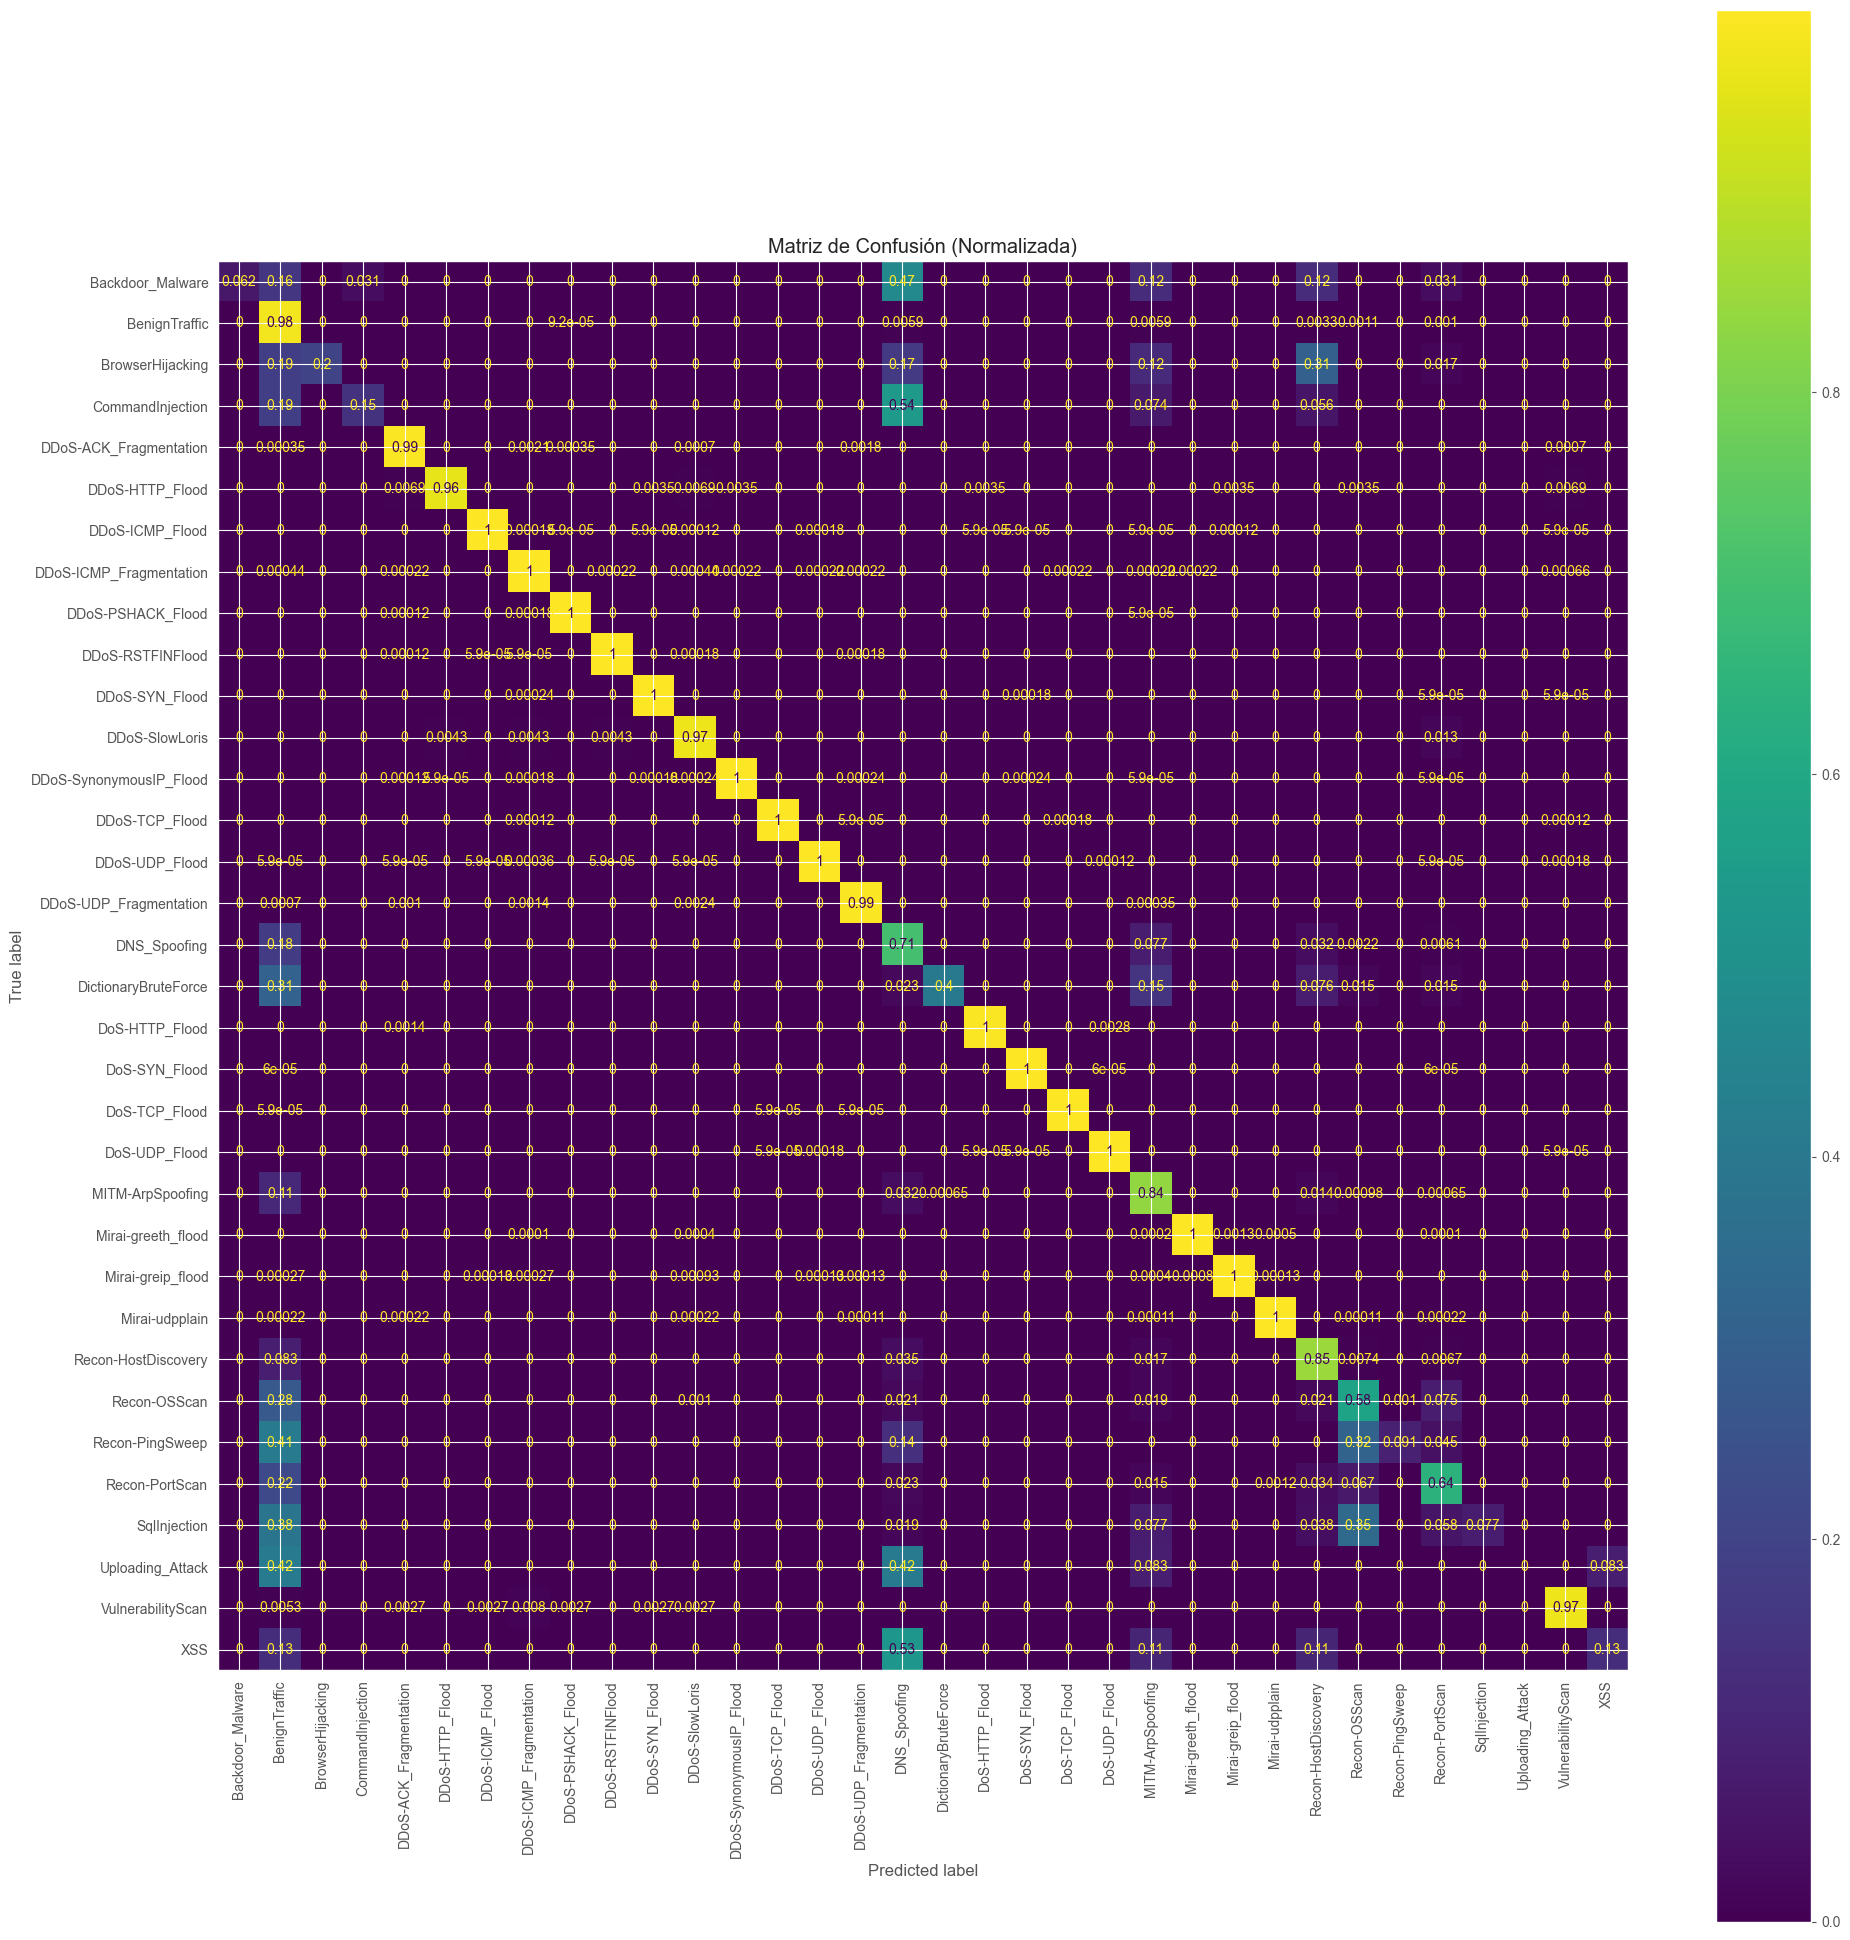

In [5]:
# ----------------------------------------------
# ETAPA 5: Modelo Base (Random Forest) y Métricas
# ----------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# (Asumimos que 'le' (LabelEncoder) de la Etapa 2 todavía existe)
# 'le.classes_' contiene los nombres (ej. 'BenignTraffic')

# --- 1. Definir y Entrenar el Modelo ---
print("\n--- Iniciando Entrenamiento del Modelo Base (Random Forest) ---")

# n_jobs=-1 usa todos los cores de tu CPU para ir más rápido
# 'random_state=42' es para que el resultado sea reproducible
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)

# ¡El entrenamiento!
rf_model.fit(X_train, y_train)

print("¡Entrenamiento completado!")


# --- 2. Hacer Predicciones ---
print("Realizando predicciones en el set de prueba (X_test)...")
y_pred = rf_model.predict(X_test)


# --- 3. Evaluar el Modelo ---

print("\n--- Reporte de Clasificación ---")
# 'target_names' usa nuestro 'le' para poner los nombres
# de los ataques en el reporte.
report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
)
print(report)

# --- 4. Visualizar la Matriz de Confusión ---
print("Generando Matriz de Confusión...")
# (Esto puede ser un gráfico muy grande si hay muchas clases)

fig, ax = plt.subplots(figsize=(20, 20)) # Ajustar tamaño
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    ax=ax,
    xticks_rotation='vertical',
    normalize='true', # Muestra porcentajes
    labels=le.transform(le.classes_), # Asegura el orden
    display_labels=le.classes_
)
plt.title("Matriz de Confusión (Normalizada)")
plt.tight_layout()
plt.show()

Forma original de X_train: (905436, 26)
Forma original de y_train: (905436,)

Iniciando SMOTE... (Esto puede tardar varios minutos)
SMOTE completado en 24.19 segundos.

Forma NUEVA de X_train (SMOTE): (2298400, 26)
Forma NUEVA de y_train (SMOTE): (2298400,)

--- Iniciando Entrenamiento del RandomForest (con SMOTE) ---
¡Entrenamiento (SMOTE) completado!

Realizando predicciones en el set de prueba original (X_test)...

--- Reporte de Clasificación (Modelo con SMOTE) ---
                         precision    recall  f1-score   support

       Backdoor_Malware       0.43      0.28      0.34        32
          BenignTraffic       0.93      0.93      0.93     10845
       BrowserHijacking       0.47      0.44      0.46        59
       CommandInjection       0.56      0.54      0.55        54
 DDoS-ACK_Fragmentation       0.99      0.99      0.99      2851
        DDoS-HTTP_Flood       0.95      0.97      0.96       288
        DDoS-ICMP_Flood       1.00      1.00      1.00     16900
DDoS-

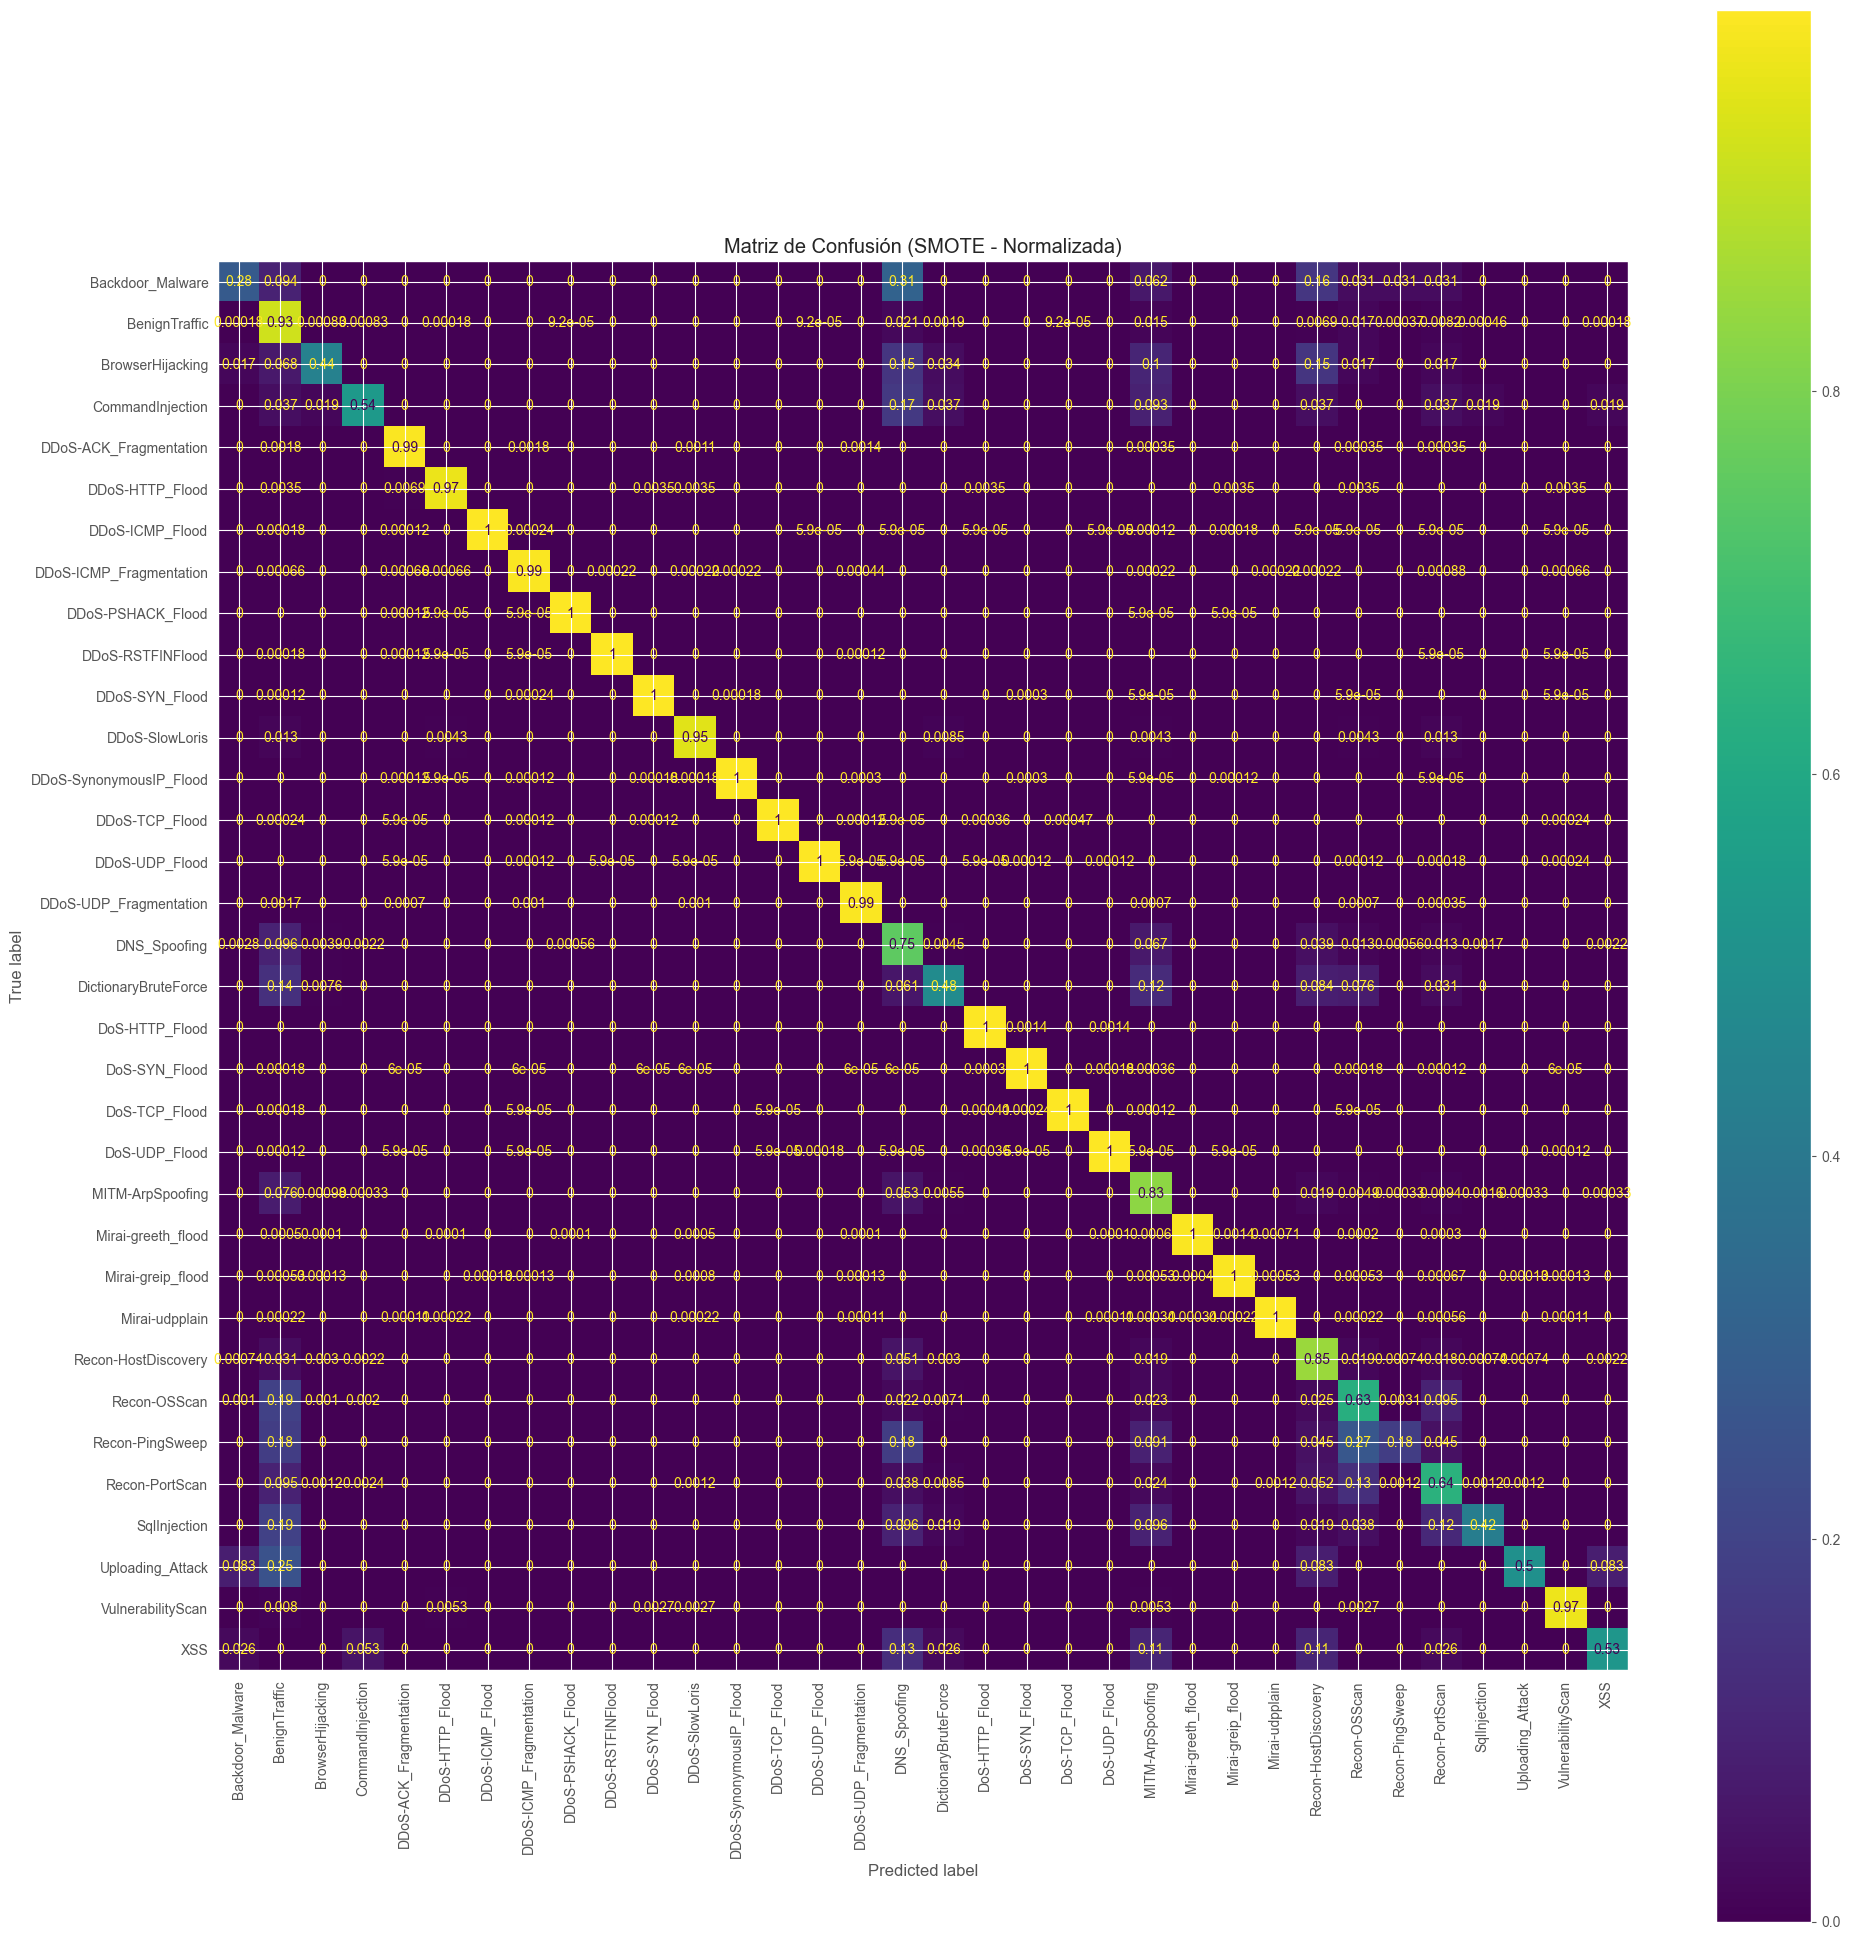

In [6]:
# ----------------------------------------------
# ETAPA 6: Remuestreo con SMOTE y Re-evaluación (Corregido)
# ----------------------------------------------
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# (Asumimos que 'X_train', 'y_train', 'X_test', 'y_test'
#  y 'le' (LabelEncoder) de las etapas 4 y 5 todavía existen)

print(f"Forma original de X_train: {X_train.shape}")
print(f"Forma original de y_train: {y_train.shape}")

# --- 1. Configurar y Aplicar SMOTE ---
# 'auto' sobremuestrea todas las clases minoritarias
# para igualar a la clase mayoritaria.

print("\nIniciando SMOTE... (Esto puede tardar varios minutos)")

#################################################################
# --- CORRECCIÓN ---
# Se eliminó el argumento 'n_jobs=-1', que no es válido para SMOTE.
#################################################################
smote = SMOTE(sampling_strategy='auto', random_state=42)
#################################################################


start_time = time.time()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
end_time = time.time()

print(f"SMOTE completado en {end_time - start_time:.2f} segundos.")
print(f"\nForma NUEVA de X_train (SMOTE): {X_train_smote.shape}")
print(f"Forma NUEVA de y_train (SMOTE): {y_train_smote.shape}")

# --- 2. Entrenar el RandomForest en los datos CON SMOTE ---
print("\n--- Iniciando Entrenamiento del RandomForest (con SMOTE) ---")
# Aquí SÍ usamos n_jobs=-1
rf_model_smote = RandomForestClassifier(n_jobs=-1, random_state=42)

rf_model_smote.fit(X_train_smote, y_train_smote)
print("¡Entrenamiento (SMOTE) completado!")


# --- 3. Evaluar el Modelo (SMOTE) ---
print("\nRealizando predicciones en el set de prueba original (X_test)...")
y_pred_smote = rf_model_smote.predict(X_test)


# --- 4. Reporte de Clasificación (SMOTE) ---
print("\n--- Reporte de Clasificación (Modelo con SMOTE) ---")
report_smote = classification_report(
    y_test,
    y_pred_smote,
    target_names=le.classes_
)
print(report_smote)


# --- 5. Matriz de Confusión (SMOTE) ---
print("Generando Matriz de Confusión (Modelo con SMOTE)...")
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_smote,
    ax=ax,
    xticks_rotation='vertical',
    normalize='true',
    labels=le.transform(le.classes_),
    display_labels=le.classes_
)
plt.title("Matriz de Confusión (SMOTE - Normalizada)")
plt.tight_layout()
plt.show()

In [7]:
# ----------------------------------------------
# Celda de Verificación de GPU (Antes de la Etapa 7)
# ----------------------------------------------
import tensorflow as tf

print(f"Versión de TensorFlow: {tf.__version__}")

# Esta es la función clave
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("\n--- ¡ADVERTENCIA! ---")
    print("TensorFlow NO PUEDE encontrar tu GPU (GTX 1650).")
    print("El entrenamiento de la Etapa 7 se ejecutará en el CPU (será MUY lento).")
    print("Posible solución: Debes instalar NVIDIA CUDA Toolkit y cuDNN.")
else:
    print("\n--- ¡ÉXITO! ---")
    print(f"TensorFlow SÍ detectó tu GPU:")
    for device in gpu_devices:
        print(f"  - {device.name}")
    print("\nEl entrenamiento de la Etanpa 7 usará la GPU y será mucho más rápido.")

Versión de TensorFlow: 2.20.0

--- ¡ADVERTENCIA! ---
TensorFlow NO PUEDE encontrar tu GPU (GTX 1650).
El entrenamiento de la Etapa 7 se ejecutará en el CPU (será MUY lento).
Posible solución: Debes instalar NVIDIA CUDA Toolkit y cuDNN.


In [22]:
# ----------------------------------------------
# ETAPA 7: Modelo de IA (Temporal Convolutional Network - TCN)
# ----------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from tcn import TCN # Importar TCN
from sklearn.metrics import classification_report
import time

# (Asumimos que 'X_train_smote', 'y_train_smote', 'X_test', 'y_test'
#  y 'le' (LabelEncoder) de las etapas anteriores todavía existen)

# --- 1. Preparar Datos para TCN (Reshape 2D -> 3D) ---
print("--- Preparando datos para TCN (3D) ---")

# a. Obtener los valores de X (como arrays de NumPy)
# Usamos .values para obtener los datos sin el índice de Pandas
X_train_vals = X_train_smote.values
X_test_vals = X_test.values

# b. Obtener el número de features y clases
N_FEATURES = X_train_vals.shape[1] # Debería ser 46
N_CLASSES = len(le.classes_)      # Debería ser 34
TIMESTEPS = 1                     # Nuestro "truco"

# c. Reformatear X a 3D: (muestras, timesteps, features)
X_train_3D = X_train_vals.reshape((X_train_vals.shape[0], TIMESTEPS, N_FEATURES))
X_test_3D = X_test_vals.reshape((X_test_vals.shape[0], TIMESTEPS, N_FEATURES))

print(f"Forma de X_train (original 2D): {X_train_vals.shape}")
print(f"Forma de X_train (nueva 3D):  {X_train_3D.shape}")
print(f"Forma de X_test (original 2D):  {X_test_vals.shape}")
print(f"Forma de X_test (nueva 3D):   {X_test_3D.shape}")

# d. Codificar 'y' (One-Hot Encoding)
# Keras prefiere que las clases (0, 1, 2... 33)
# estén en formato "categórico" (One-Hot)
y_train_cat = to_categorical(y_train_smote, num_classes=N_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=N_CLASSES)

print(f"\nForma de y_train (categórica): {y_train_cat.shape}")
print(f"Forma de y_test (categórica):  {y_test_cat.shape}")


# --- 2. Construir el Modelo TCN ---
print("\n--- Construyendo el modelo TCN ---")

# Aquí puedes "jugar con los parámetros" que mencionaste
model_tcn = Sequential([
    TCN(
        input_shape=(TIMESTEPS, N_FEATURES), # (1, 46)
        nb_filters=64,       # Número de filtros (neuronas) en cada capa
        kernel_size=2,       # Tamaño del kernel de convolución
        dilations=[1, 2, 4], # Lista de dilataciones
        nb_stacks=1,         # Número de "bloques" TCN
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,    # Dropout para regularización
        return_sequences= True
    ),
    Dropout(0.2), # Dropout adicional antes de la capa final
    BatchNormalization(),
    TCN(
        nb_filters=128,
        kernel_size=3,
        dilations=[1, 2],
        nb_stacks=1,
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.1,
        return_sequences=False # False porque queremos UNA salida (no una secuencia)
    ),
    Dropout(0.2),
    Dense(N_CLASSES, activation='softmax') # Capa final de 34 neuronas
])

# Compilar el modelo
model_tcn.compile(
    optimizer='adam',                   # Optimizador popular
    loss='categorical_crossentropy',    # Pérdida para multi-clase
    metrics=['accuracy']                # Métrica a monitorear
)

model_tcn.summary()

--- Preparando datos para TCN (3D) ---
Forma de X_train (original 2D): (2298400, 26)
Forma de X_train (nueva 3D):  (2298400, 1, 26)
Forma de X_test (original 2D):  (226360, 26)
Forma de X_test (nueva 3D):   (226360, 1, 26)

Forma de y_train (categórica): (2298400, 34)
Forma de y_test (categórica):  (226360, 34)

--- Construyendo el modelo TCN ---


C:\Users\julia\PycharmProjects\SNIFFER-IDS-IOT\.venv\Lib\site-packages\tcn\tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_22 (TCN)                    │ (None, 1, 64)          │        46,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_23 (TCN)                    │ (None, 128)            │       180,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,906 (905.88 KB)

 Trainable params: 231,778 (905.38 KB)

 Non-trainable params: 128 (512.00 B)

In [23]:
# --- 3. Entrenar el Modelo TCN ---
print("\n--- Iniciando Entrenamiento de la TCN ---")
print("Esto puede tardar bastante...")

# (Si tienes una GPU, TensorFlow la usará automáticamente)
start_time = time.time()

# Entrenamos el modelo.
# batch_size=256 o 512 es bueno para datasets grandes
history = model_tcn.fit(
    X_train_3D,
    y_train_cat,
    epochs=5, # 10 "pasadas" por los datos. Puedes subirlo si tienes tiempo.
    batch_size=256,
    validation_data=(X_test_3D, y_test_cat) # Validamos con los datos de test
)

end_time = time.time()
print(f"Entrenamiento de TCN completado en {end_time - start_time:.2f} segundos.")


# --- 4. Evaluar el Modelo TCN ---
print("\n--- Reporte de Clasificación (Modelo TCN) ---")

# Predecir sobre X_test_3D
y_pred_probs = model_tcn.predict(X_test_3D)

# Las predicciones 'y_pred_probs' son probabilidades.
# Necesitamos la clase con la probabilidad más alta (argmax)
y_pred_tcn = np.argmax(y_pred_probs, axis=1)

# Generar el reporte
# Comparamos 'y_test' (los números 0-33) con 'y_pred_tcn'
report_tcn = classification_report(
    y_test,
    y_pred_tcn,
    target_names=le.classes_
)
print(report_tcn)


--- Iniciando Entrenamiento de la TCN ---
Esto puede tardar bastante...
Epoch 1/5
8979/8979 ━━━━━━━━━━━━━━━━━━━━ 362s 40ms/step - accuracy: 0.5922 - loss: 1.0825 - val_accuracy: 0.6958 - val_loss: 0.5891
Epoch 2/5
8979/8979 ━━━━━━━━━━━━━━━━━━━━ 283s 32ms/step - accuracy: 0.6589 - loss: 0.8806 - val_accuracy: 0.7041 - val_loss: 0.5785
Epoch 3/5
8979/8979 ━━━━━━━━━━━━━━━━━━━━ 272s 30ms/step - accuracy: 0.6775 - loss: 0.8231 - val_accuracy: 0.7163 - val_loss: 0.5708
Epoch 4/5
8979/8979 ━━━━━━━━━━━━━━━━━━━━ 280s 31ms/step - accuracy: 0.6879 - loss: 0.7914 - val_accuracy: 0.7190 - val_loss: 0.5674
Epoch 5/5
8979/8979 ━━━━━━━━━━━━━━━━━━━━ 281s 31ms/step - accuracy: 0.6958 - loss: 0.7697 - val_accuracy: 0.7313 - val_loss: 0.5676
Entrenamiento de TCN completado en 1477.59 segundos.

--- Reporte de Clasificación (Modelo TCN) ---
7074/7074 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step
                         precision    recall  f1-score   support

       Backdoor_Malware       0.01      0.25      0.03   

In [24]:
# ----------------------------------------------
# ETAPA 8: Guardar el Modelo y Artefactos
# ----------------------------------------------
import joblib
import os

print("--- Guardando el sistema completo ---")

# 1. Guardar el Modelo TCN (.keras es el formato moderno de TensorFlow)
model_filename = 'modelo_tcn_iot.keras'
model_tcn.save(model_filename)
print(f"✅ Modelo guardado como: {model_filename}")

# 2. Guardar el Scaler (MinMaxScaler)
scaler_filename = 'scaler_entrenado.joblib'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler guardado como: {scaler_filename}")

# 3. Guardar el LabelEncoder
le_filename = 'label_encoder_entrenado.joblib'
joblib.dump(le, le_filename)
print(f"✅ LabelEncoder guardado como: {le_filename}")

print("\n¡Todo listo! Copia estos 3 archivos a la carpeta donde correrás tu script final.")

--- Guardando el sistema completo ---
✅ Modelo guardado como: modelo_tcn_iot.keras
✅ Scaler guardado como: scaler_entrenado.joblib
✅ LabelEncoder guardado como: label_encoder_entrenado.joblib

¡Todo listo! Copia estos 3 archivos a la carpeta donde correrás tu script final.


In [ ]:
# ----------------------------------------------
# Script de Inferencia (Uso futuro)
# ----------------------------------------------
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from tcn import TCN # ¡Necesitas importar esto para cargar el modelo!

# --- 1. Cargar los artefactos ---
print("Cargando cerebro de la IA...")

# Cargar Scaler y Encoder
scaler = joblib.load('scaler_entrenado.joblib')
le = joblib.load('label_encoder_entrenado.joblib')

# Cargar Modelo TCN
# Usamos custom_objects para que Keras entienda la capa TCN
model = load_model('modelo_tcn_iot.keras', custom_objects={'TCN': TCN})

print("¡Sistema cargado y listo para detectar ataques!")

# --- 2. Ejemplo de cómo predecir un NUEVO dato ---

def predecir_trafico(datos_nuevos_df):
    """
    datos_nuevos_df: Un DataFrame con las 46 columnas EXACTAS
                     que usaste para entrenar (flow_duration, etc.)
                     y en el MISMO ORDEN.
    """

    # A. Preprocesamiento (Escalar)
    # Usamos .transform, NO .fit_transform
    X_scaled = scaler.transform(datos_nuevos_df)

    # B. Reformatear a 3D para la TCN (1 muestra, 1 timestep, 46 features)
    # Asumimos que datos_nuevos_df tiene 1 sola fila para predicción en tiempo real
    X_3D = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # C. Predicción
    pred_probs = model.predict(X_3D, verbose=0) # verbose=0 para que no llene la consola
    pred_class_index = np.argmax(pred_probs, axis=1)

    # D. Decodificar (Número -> Nombre del Ataque)
    nombre_ataque = le.inverse_transform(pred_class_index)

    # E. Probabilidad (Confianza)
    confianza = np.max(pred_probs)

    return nombre_ataque[0], confianza

# --- PRUEBA SIMULADA ---
# Imaginemos que acabas de capturar un paquete y extraer sus features
# (Aquí creo datos falsos aleatorios solo para probar el código)
fake_data = pd.DataFrame(np.random.rand(1, 46), columns=scaler.feature_names_in_)

ataque, prob = predecir_trafico(fake_data)

print(f"\n--- Resultado del Análisis ---")
print(f"Predicción: {ataque}")
print(f"Confianza:  {prob:.2%}")

if ataque == "BenignTraffic":
    print("🟢 Tráfico Seguro")
else:
    print("🔴 ¡ALERTA! Ataque Detectado")